In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load signal data
signals = pd.read_csv('../outputs/signal_dataset.csv', parse_dates=['Date'], index_col='Date')

# Normalize composite signal again (optional, for trading weight scaling)
signals['Signal'] = (signals['Composite_Signal'] - signals['Composite_Signal'].mean()) / signals['Composite_Signal'].std()


In [2]:
# Simulate stock price (Tata Motors) if you don’t have actual price
np.random.seed(1)
price = pd.Series(500 + np.cumsum(np.random.normal(0, 5, len(signals))), index=signals.index)
price.name = 'Price'

signals = signals.join(price)


In [3]:
# Strategy: Long if signal > 0, Short if < 0
signals['Position'] = np.sign(signals['Signal'])

# Calculate daily returns
signals['Returns'] = signals['Price'].pct_change()

# Strategy returns
signals['Strategy_Returns'] = signals['Position'].shift(1) * signals['Returns']


In [4]:
def sharpe_ratio(returns, risk_free=0):
    excess = returns - risk_free
    return np.sqrt(252) * excess.mean() / excess.std()

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

# Cumulative returns
signals['Cumulative_Strategy'] = (1 + signals['Strategy_Returns']).cumprod()
signals['Cumulative_Benchmark'] = (1 + signals['Returns']).cumprod()

# Metrics
ann_return = (signals['Cumulative_Strategy'].iloc[-1])**(252/len(signals)) - 1
sharpe = sharpe_ratio(signals['Strategy_Returns'])
mdd = max_drawdown(signals['Cumulative_Strategy'])

# Daily turnover
signals['Turnover'] = signals['Position'].diff().abs()
avg_turnover = signals['Turnover'].mean()

print(f"📈 Annualized Return: {ann_return:.2%}")
print(f"📉 Max Drawdown: {mdd:.2%}")
print(f"⚖️ Sharpe Ratio: {sharpe:.2f}")
print(f"🔄 Avg Daily Turnover: {avg_turnover:.2%}")


📈 Annualized Return: -27.04%
📉 Max Drawdown: -11.70%
⚖️ Sharpe Ratio: -2.03
🔄 Avg Daily Turnover: 57.97%


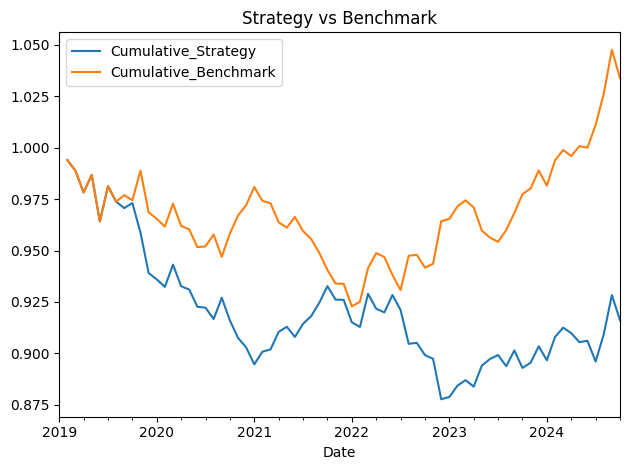

In [5]:
# Save to CSV
signals.to_csv('../outputs/backtest_results.csv')

# Plot returns
signals[['Cumulative_Strategy', 'Cumulative_Benchmark']].plot(title='Strategy vs Benchmark')
plt.tight_layout()
plt.savefig('../outputs/strategy_vs_benchmark.png')
plt.show()
